<center>
    <h1> Best N value </h1>
    <h3> Name: Prerak Shah, Sai Sri Meghana Dharmapuri </h3>
</center>

# 1. Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [3]:
df_stock = pd.read_csv('CSC215_P2_Stock_Price.csv')

In [4]:
df_stock.shape

(4392, 7)

In [5]:
df_stock.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


# Data Cleaning 

# 2.Drop Date and Adj_Close columns

In [6]:
# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock
df_stock_new.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [7]:
# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj_Close'], axis=1)
df_stock_new.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [8]:
df_stock_new.shape

(4392, 5)

In [9]:
df_stock.shape

(4392, 7)

# 3. Removing null values 

In [10]:
df_stock_new.shape

(4392, 5)

In [11]:
#Calling sum() of the DataFrame returned by isnull() will give a series containing data about count of NaN in each column
df_stock_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [12]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [13]:
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625


# 4. Normalizing the columns 

In [14]:
#Normalizing the training numeric values using zscore
from scipy.stats import zscore
df_stock_new['Open'] = zscore(df_stock_new['Open'])
df_stock_new['High'] = zscore(df_stock_new['High'])
df_stock_new['Low'] = zscore(df_stock_new['Low'])
df_stock_new['Close'] = zscore(df_stock_new['Close'])
df_stock_new['Volume'] = zscore(df_stock_new['Volume'])

In [15]:
x=df_stock_new.as_matrix(columns=['Open','High','Low','Volume','Close'])

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [16]:
x.shape

(4392, 5)

In [17]:
df_stock_new.shape

(4392, 6)

In [18]:
y=df_stock_new['y'].tolist()

In [19]:
y=np.array(y)

In [20]:
y.shape

(4392,)

# 5. Data Transformation

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

Shape of x_seq: (4386, 6, 1, 5)
Shape of y_seq: (4386,)



Model trained for adam optimizer and sigmoid activation function for 6 days: 

Train on 3070 samples, validate on 1316 samples
Epoch 1/200
3070/3070 - 2s - loss: 1748.3470 - val_loss: 1543.3072
Epoch 2/200
3070/3070 - 0s - loss: 1569.9765 - val_loss: 1433.5247
Epoch 3/200
3070/3070 - 0s - loss: 1476.6957 - val_loss: 1355.9562
Epoch 4/200
3070/3070 - 0s - loss: 1400.1489 - val_loss: 1285.0192
Epoch 5/200
3070/3070 - 0s - loss: 1331.5771 - val_loss: 1224.6098
Epoch 6/200
3070/3070 - 0s - loss: 1272.5509 - val_loss: 1172.4250
Epoch 7/200
3070/3070 - 0s - loss: 1220.9036 - val_loss: 1126.1920
Epoch 8/200
3070/3070 - 0s - loss: 1175.0387 - val_loss: 1085.0243
Epoch 9/200
3070/3070 - 0s - loss: 1131.6777 - val_loss: 1041.4270
Epoch 10/200
3070/3070 - 0s - loss: 1078.0341 - val_loss: 982.0822
Epoch 11/200
3070/3070 - 0s - loss: 1021.9026 - val_loss: 931.4987
Epoch 12/200
3070/3070 - 0s - loss: 971.0587 - val_loss: 882.8558
Epoch 13/20

Epoch 125/200
3070/3070 - 0s - loss: 1.1776 - val_loss: 1.5160
Epoch 126/200
3070/3070 - 0s - loss: 1.1123 - val_loss: 0.9629
Epoch 127/200
3070/3070 - 0s - loss: 1.0680 - val_loss: 1.4157
Epoch 128/200
3070/3070 - 0s - loss: 1.0997 - val_loss: 0.8591
Epoch 129/200
3070/3070 - 0s - loss: 1.0876 - val_loss: 1.3507
Epoch 130/200
3070/3070 - 0s - loss: 1.0750 - val_loss: 1.3954
Epoch 131/200
3070/3070 - 0s - loss: 1.0937 - val_loss: 0.9077
Epoch 132/200
3070/3070 - 0s - loss: 1.0359 - val_loss: 0.8673
Epoch 133/200
3070/3070 - 0s - loss: 1.0244 - val_loss: 0.9125
Epoch 00133: early stopping


Final score (MSE): 0.8590814994681539
Final score (RMSE): 0.926866494953914


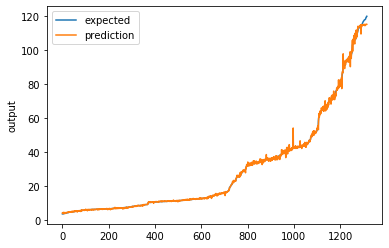

In [22]:
SEQUENCE_SIZE = 6
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4386,30)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 6 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4387, 5, 1, 5)
Shape of y_seq: (4387,)



Model trained for adam optimizer and sigmoid activation function for 5 days: 

Train on 3070 samples, validate on 1317 samples
Epoch 1/200
3070/3070 - 1s - loss: 1778.5764 - val_loss: 1611.3631
Epoch 2/200
3070/3070 - 0s - loss: 1621.9385 - val_loss: 1507.8317
Epoch 3/200
3070/3070 - 0s - loss: 1528.4932 - val_loss: 1424.1911
Epoch 4/200
3070/3070 - 0s - loss: 1450.2136 - val_loss: 1354.1306
Epoch 5/200
3070/3070 - 0s - loss: 1383.5749 - val_loss: 1293.2385
Epoch 6/200
3070/3070 - 0s - loss: 1324.4554 - val_loss: 1238.7659
Epoch 7/200
3070/3070 - 0s - loss: 1266.8582 - val_loss: 1179.6858
Epoch 8/200
3070/3070 - 0s - loss: 1200.7461 - val_loss: 1113.5691
Epoch 9/200
3070/3070 - 0s - loss: 1140.9356 - val_loss: 1063.2928
Epoch 10/200
3070/3070 - 0s - loss: 1084.6683 - val_loss: 993.8510
Epoch 11/200
3070/3070 - 0s - loss: 1006.0110 - val_loss: 918.9881
Epoch 12/200
3070/3070 - 0s - loss: 939.9962 - val_loss: 859.0574
Epoch 13/20

3070/3070 - 0s - loss: 1.0688 - val_loss: 0.9079
Epoch 126/200
3070/3070 - 0s - loss: 1.1226 - val_loss: 0.8105
Epoch 127/200
3070/3070 - 0s - loss: 1.0268 - val_loss: 1.0506
Epoch 128/200
3070/3070 - 0s - loss: 1.0220 - val_loss: 0.9320
Epoch 129/200
3070/3070 - 0s - loss: 1.0623 - val_loss: 0.7488
Epoch 130/200
3070/3070 - 0s - loss: 1.0023 - val_loss: 1.0787
Epoch 131/200
3070/3070 - 0s - loss: 1.0915 - val_loss: 0.9153
Epoch 132/200
3070/3070 - 0s - loss: 1.0565 - val_loss: 0.8389
Epoch 133/200
3070/3070 - 0s - loss: 0.9307 - val_loss: 0.8122
Epoch 134/200
3070/3070 - 0s - loss: 1.0294 - val_loss: 0.7759
Epoch 00134: early stopping


Final score (MSE): 0.7487857384346115
Final score (RMSE): 0.865324065558454


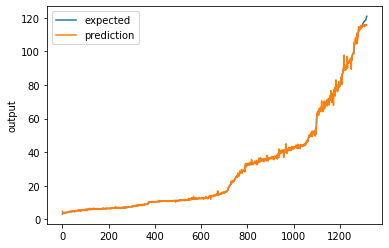

In [23]:
SEQUENCE_SIZE = 5
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4387,25)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 5 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4388, 4, 1, 5)
Shape of y_seq: (4388,)



Model trained for adam optimizer and sigmoid activation function for 4 days: 

Train on 3071 samples, validate on 1317 samples
Epoch 1/200
3071/3071 - 1s - loss: 1758.8218 - val_loss: 1586.7090
Epoch 2/200
3071/3071 - 0s - loss: 1587.9036 - val_loss: 1468.1242
Epoch 3/200
3071/3071 - 0s - loss: 1475.3002 - val_loss: 1369.0211
Epoch 4/200
3071/3071 - 0s - loss: 1381.3821 - val_loss: 1288.4309
Epoch 5/200
3071/3071 - 0s - loss: 1304.2983 - val_loss: 1221.3571
Epoch 6/200
3071/3071 - 0s - loss: 1238.8137 - val_loss: 1163.9416
Epoch 7/200
3071/3071 - 0s - loss: 1182.1469 - val_loss: 1112.6234
Epoch 8/200
3071/3071 - 0s - loss: 1128.1933 - val_loss: 1063.4043
Epoch 9/200
3071/3071 - 0s - loss: 1075.1793 - val_loss: 1012.0278
Epoch 10/200
3071/3071 - 0s - loss: 1000.5256 - val_loss: 920.1640
Epoch 11/200
3071/3071 - 0s - loss: 921.9181 - val_loss: 856.4602
Epoch 12/200
3071/3071 - 0s - loss: 860.2615 - val_loss: 801.3891
Epoch 13/200

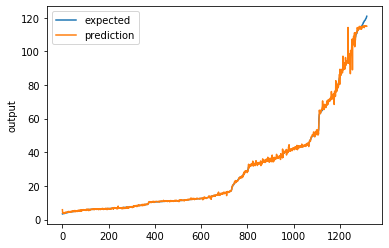

In [24]:
SEQUENCE_SIZE = 4
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4388,20)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 4 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4389, 3, 1, 5)
Shape of y_seq: (4389,)



Model trained for adam optimizer and sigmoid activation function for 3 days: 

Train on 3072 samples, validate on 1317 samples
Epoch 1/200
3072/3072 - 1s - loss: 1757.7227 - val_loss: 1470.9486
Epoch 2/200
3072/3072 - 0s - loss: 1566.7667 - val_loss: 1345.1220
Epoch 3/200
3072/3072 - 0s - loss: 1451.5712 - val_loss: 1244.7910
Epoch 4/200
3072/3072 - 0s - loss: 1347.8357 - val_loss: 1160.2120
Epoch 5/200
3072/3072 - 0s - loss: 1265.7914 - val_loss: 1092.7218
Epoch 6/200
3072/3072 - 0s - loss: 1194.4812 - val_loss: 1032.4683
Epoch 7/200
3072/3072 - 0s - loss: 1134.3210 - val_loss: 985.0522
Epoch 8/200
3072/3072 - 0s - loss: 1086.2502 - val_loss: 948.1301
Epoch 9/200
3072/3072 - 0s - loss: 1041.3067 - val_loss: 889.2601
Epoch 10/200
3072/3072 - 0s - loss: 948.2347 - val_loss: 796.3675
Epoch 11/200
3072/3072 - 0s - loss: 874.5729 - val_loss: 738.2798
Epoch 12/200
3072/3072 - 0s - loss: 814.0360 - val_loss: 686.2887
Epoch 13/200
307

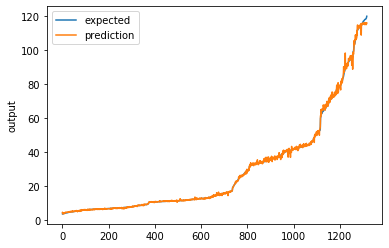

In [25]:
SEQUENCE_SIZE = 3
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4389,15)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 3 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4390, 2, 1, 5)
Shape of y_seq: (4390,)



Model trained for adam optimizer and sigmoid activation function for 2 days: 

Train on 3073 samples, validate on 1317 samples
Epoch 1/200
3073/3073 - 1s - loss: 1666.1557 - val_loss: 1528.7125
Epoch 2/200
3073/3073 - 0s - loss: 1468.8441 - val_loss: 1391.1404
Epoch 3/200
3073/3073 - 1s - loss: 1354.5512 - val_loss: 1296.3374
Epoch 4/200
3073/3073 - 0s - loss: 1262.9066 - val_loss: 1212.4444
Epoch 5/200
3073/3073 - 0s - loss: 1186.1365 - val_loss: 1146.1337
Epoch 6/200
3073/3073 - 0s - loss: 1123.3303 - val_loss: 1087.7734
Epoch 7/200
3073/3073 - 1s - loss: 1066.8251 - val_loss: 1039.8471
Epoch 8/200
3073/3073 - 0s - loss: 1024.3973 - val_loss: 1003.1929
Epoch 9/200
3073/3073 - 0s - loss: 984.9395 - val_loss: 941.8717
Epoch 10/200
3073/3073 - 0s - loss: 887.8464 - val_loss: 839.2723
Epoch 11/200
3073/3073 - 0s - loss: 810.8983 - val_loss: 774.2692
Epoch 12/200
3073/3073 - 0s - loss: 750.5757 - val_loss: 719.2744
Epoch 13/200
30

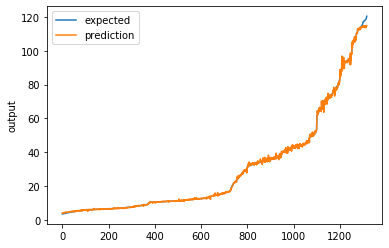

In [26]:
SEQUENCE_SIZE = 2
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4390,10)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 2 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4391, 1, 1, 5)
Shape of y_seq: (4391,)



Model trained for adam optimizer and sigmoid activation function for 1 day: 

Train on 3073 samples, validate on 1318 samples
Epoch 1/200
3073/3073 - 2s - loss: 1643.9682 - val_loss: 1515.2966
Epoch 2/200
3073/3073 - 0s - loss: 1455.7879 - val_loss: 1384.8899
Epoch 3/200
3073/3073 - 0s - loss: 1341.1182 - val_loss: 1288.1745
Epoch 4/200
3073/3073 - 0s - loss: 1250.5883 - val_loss: 1207.0347
Epoch 5/200
3073/3073 - 0s - loss: 1173.3059 - val_loss: 1139.4781
Epoch 6/200
3073/3073 - 0s - loss: 1110.4932 - val_loss: 1086.3982
Epoch 7/200
3073/3073 - 0s - loss: 1063.4815 - val_loss: 1045.6774
Epoch 8/200
3073/3073 - 0s - loss: 1025.5857 - val_loss: 1012.3954
Epoch 9/200
3073/3073 - 0s - loss: 993.7023 - val_loss: 985.3380
Epoch 10/200
3073/3073 - 0s - loss: 968.4431 - val_loss: 964.1822
Epoch 11/200
3073/3073 - 0s - loss: 948.8770 - val_loss: 948.2181
Epoch 12/200
3073/3073 - 0s - loss: 933.5784 - val_loss: 935.2485
Epoch 13/200
307

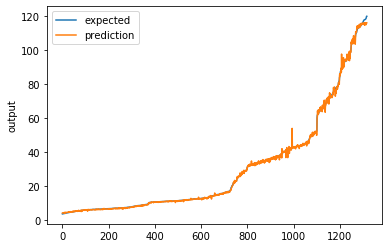

In [27]:
SEQUENCE_SIZE = 1
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4391,5)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 1 day: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)